# Description of Data

To predict: 
FVC: Forced Vital Capacity of the lungs

Variables:
1. Age
2. Sex
3. Patient ID
4. Weeks pre/post the baseline CT scan
5. Smoking Status
6. Percent of FVC as compared to normal
7. Baseline CT scan of the patient


Submission format:
1. Patient id + week conatenated
2. FVC predicted
3. Confidence of prediction

# Imports

In [3]:
!pip install ../input/kerasapplications/keras-team-keras-applications-3b180cb -f ./ --no-index
!pip install ../input/efficientnet/efficientnet-1.1.0/ -f ./ --no-index

Looking in links: ./
Processing /kaggle/input/kerasapplications/keras-team-keras-applications-3b180cb
  Created wheel for Keras-Applications: filename=Keras_Applications-1.0.8-py3-none-any.whl size=50704 sha256=bbe6598f4d2aea1dbdaf5541d18e695f1518cde07b4aa80b8021425ebb30f346
  Stored in directory: /root/.cache/pip/wheels/f4/96/13/eccdd9391bd8df958d78851b98ec4dc207ba05b67b011eb70a
Successfully built Keras-Applications
Looking in links: ./
Processing /kaggle/input/efficientnet/efficientnet-1.1.0
  Created wheel for efficientnet: filename=efficientnet-1.1.0-py3-none-any.whl size=14141 sha256=06ffeebae609fd40b94aaa4d40cf574d4d695ae324a49b2b7e67e9cf9d791f66
  Stored in directory: /root/.cache/pip/wheels/24/f5/31/3cc20871288fe532128224a3f5af7b4d67efb9835bd5683522
Successfully built efficientnet


In [5]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import random

In [8]:
def seed_everything(seed):
    # setting seed for all the different cases
    random.seed(seed)
    os.environ['PHYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
seed_everything(42)

In [10]:
## Setting GPU

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

In [22]:
train_df = pd.read_csv("../input/osic-pulmonary-fibrosis-progression/train.csv")
print(train_df.head(10))
print("\n")
print("Training set shape: ", train_df.shape)

                     Patient  Weeks   FVC    Percent  Age   Sex SmokingStatus
0  ID00007637202177411956430     -4  2315  58.253649   79  Male     Ex-smoker
1  ID00007637202177411956430      5  2214  55.712129   79  Male     Ex-smoker
2  ID00007637202177411956430      7  2061  51.862104   79  Male     Ex-smoker
3  ID00007637202177411956430      9  2144  53.950679   79  Male     Ex-smoker
4  ID00007637202177411956430     11  2069  52.063412   79  Male     Ex-smoker
5  ID00007637202177411956430     17  2101  52.868646   79  Male     Ex-smoker
6  ID00007637202177411956430     29  2000  50.327126   79  Male     Ex-smoker
7  ID00007637202177411956430     41  2064  51.937594   79  Male     Ex-smoker
8  ID00007637202177411956430     57  2057  51.761449   79  Male     Ex-smoker
9  ID00009637202177434476278      8  3660  85.282878   69  Male     Ex-smoker


Training set shape:  (1549, 7)


In [21]:
test_df = pd.read_csv("../input/osic-pulmonary-fibrosis-progression/test.csv")
print(test_df.shape)

(5, 7)


In [45]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1549 entries, 0 to 1548
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Patient        1549 non-null   object 
 1   Weeks          1549 non-null   int64  
 2   FVC            1549 non-null   int64  
 3   Percent        1549 non-null   float64
 4   Age            1549 non-null   int64  
 5   Sex            1549 non-null   object 
 6   SmokingStatus  1549 non-null   object 
dtypes: float64(1), int64(3), object(3)
memory usage: 84.8+ KB


In [43]:
print("Summary of the Training variables: \n")
print("Number of patients:", train_df['Patient'].nunique())
print("\nNumber of patient visits:\n", train_df['Patient'].value_counts())
print("\nCount of smoking status:\n", train_df["SmokingStatus"].value_counts())
print("\nSex distribution: \n", train_df["Sex"].value_counts())

Summary of the Training variables: 

Number of patients: 176

Number of patient visits:
 ID00119637202215426335765    10
ID00167637202237397919352    10
ID00140637202231728595149    10
ID00343637202287577133798    10
ID00388637202301028491611    10
                             ..
ID00381637202299644114027     7
ID00111637202210956877205     7
ID00276637202271694539978     7
ID00047637202184938901501     6
ID00267637202270790561585     6
Name: Patient, Length: 176, dtype: int64

Count of smoking status:
 Ex-smoker           1038
Never smoked         429
Currently smokes      82
Name: SmokingStatus, dtype: int64

Sex distribution: 
 Male      1224
Female     325
Name: Sex, dtype: int64


Thus smoking seems to be highly correlated to low FVC of patients

Text(0, 0.5, 'Frequency')

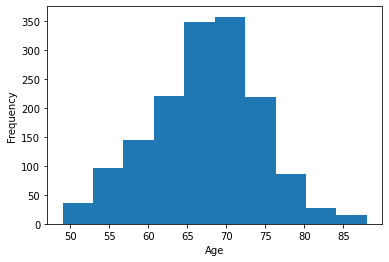

In [29]:
plt.hist(train_df["Age"])
plt.xlabel("Age")
plt.ylabel("Frequency")

Thus maximum patients affected by PF is approximately between 60 and 80

Text(0, 0.5, 'Frquency')

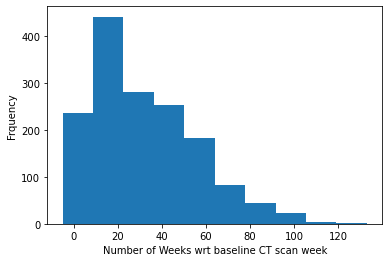

In [30]:
plt.hist(train_df["Weeks"])
plt.xlabel("Number of Weeks wrt baseline CT scan week")
plt.ylabel("Frquency")

Text(0.5, 0, 'FVC')

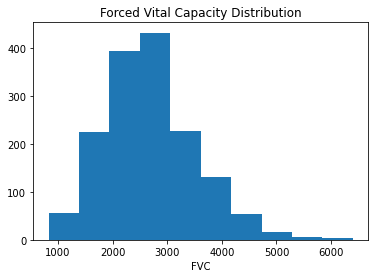

In [31]:
plt.hist(train_df['FVC'])
plt.title("Forced Vital Capacity Distribution")
plt.xlabel("FVC")

Text(0.5, 0, 'Percent of FVC of patients compared to FVC of a normal person')

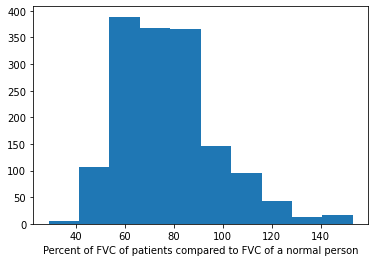

In [39]:
plt.hist(train_df["Percent"])
plt.xlabel("Percent of FVC of patients compared to FVC of a normal person")

Summary of patients having very low FVC: 


Number of patients: 
 23

Smoking status: 
 Ex-smoker       33
Never smoked    19
Name: SmokingStatus, dtype: int64

Sex distribution: 
 Male      42
Female    10
Name: Sex, dtype: int64

Age distribution: 
 (array([ 2.,  0.,  2.,  1., 10., 23.,  2.,  2.,  6.,  4.]), array([52. , 54.5, 57. , 59.5, 62. , 64.5, 67. , 69.5, 72. , 74.5, 77. ]), <a list of 10 Patch objects>)


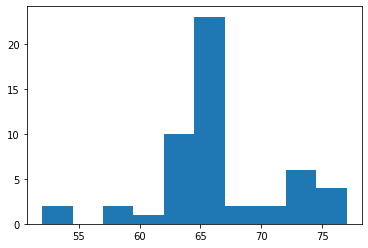

In [44]:
## Analyzing patients where percent is lower than 50%

low_percent_df = train_df[train_df["Percent"] < 50]

print("Summary of patients having very low FVC: \n")
print("\nNumber of patients: \n", low_percent_df['Patient'].nunique())
print("\nSmoking status: \n", low_percent_df['SmokingStatus'].value_counts())
print("\nSex distribution: \n", low_percent_df["Sex"].value_counts())
print("\nAge distribution: \n", plt.hist(low_percent_df["Age"]))

In [48]:
## Colouring the print statements:
from colorama import Fore, Back, Style

print(Fore.YELLOW + "Count of the number of patients in training set: ", Style.RESET_ALL, train_df['Patient'].count())
print(Fore.BLUE + "Count of the number of patients in test set: ", Style.RESET_ALL, test_df['Patient'].count())

Count of the number of patients in training set:   1549
Count of the number of patients in test set:   5


# Seeing the Images

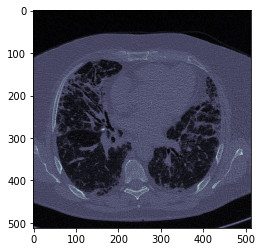

In [49]:
import pydicom

ds = pydicom.dcmread("../input/osic-pulmonary-fibrosis-progression/train/ID00123637202217151272140/137.dcm")
plt.imshow(ds.pixel_array, cmap=plt.cm.bone) 